# Comparison of Uplift modeling packages

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklift.models import SoloModel, ClassTransformation, TwoModels
from pyuplift.transformation import Lai, Kane, Jaskowski, Pessimistic, Reflective

from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.metrics import plot_gain, auuc_score

import warnings
warnings.simplefilter("ignore", UserWarning)
from datasets import HillstromDataset

data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=1)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [8]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_CTS = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='KL')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_KL = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='ED')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_ED = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='Chi')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_Chi = uplift_model.predict(X=X_test)

In [9]:
### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

In [10]:
### sklift

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)

## Visualization

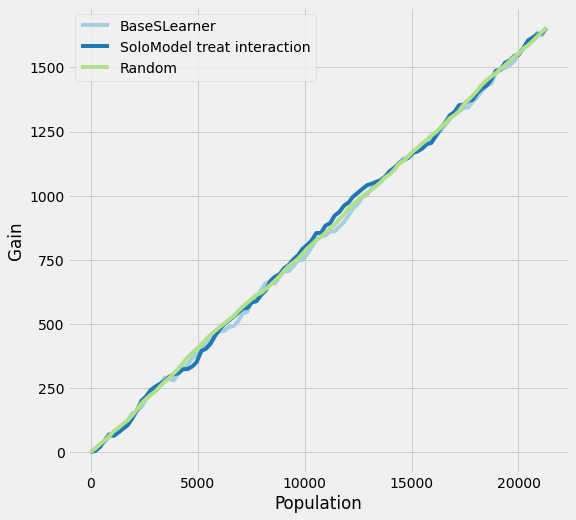

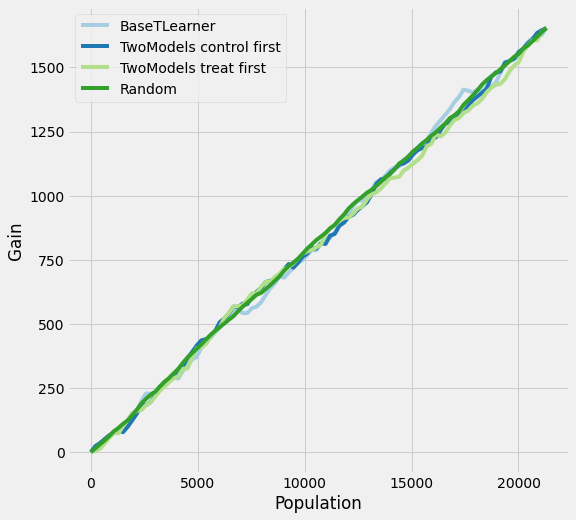

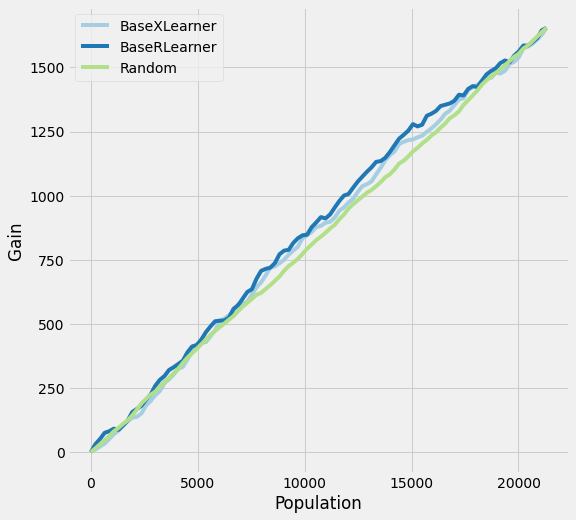

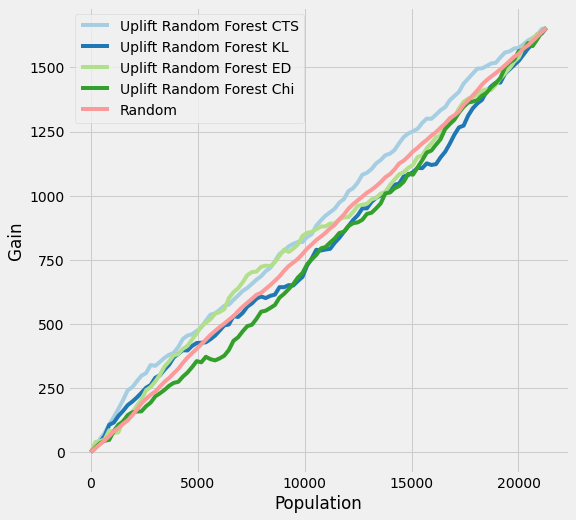

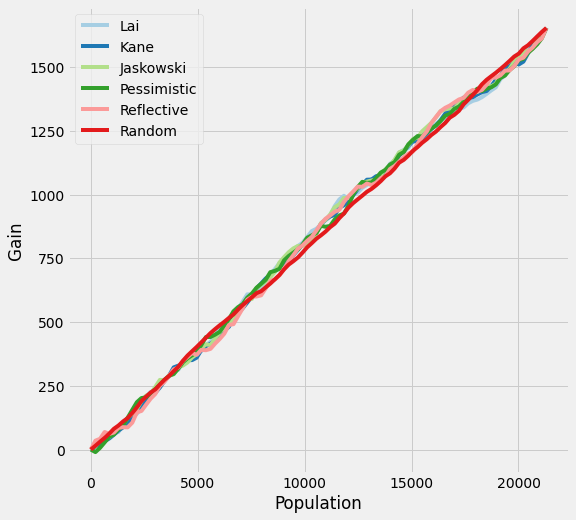

In [11]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest CTS': forest_CTS.flatten(), 'Uplift Random Forest KL': forest_KL.flatten(),
                   'Uplift Random Forest ED': forest_ED.flatten(), 'Uplift Random Forest Chi': forest_Chi.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [12]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.497448
SoloModel treat interaction    0.503039
Random                         0.503066
dtype: float64
BaseTLearner               0.499320
TwoModels control first    0.498491
TwoModels treat first      0.492717
Random                     0.503066
dtype: float64
BaseXLearner    0.514743
BaseRLearner    0.529485
Random          0.503066
dtype: float64
Uplift Random Forest CTS    0.543843
Uplift Random Forest KL     0.484939
Uplift Random Forest ED     0.513095
Uplift Random Forest Chi    0.472233
Random                      0.503066
dtype: float64
Lai            0.507456
Kane           0.504761
Jaskowski      0.509110
Pessimistic    0.506799
Reflective     0.504277
Random         0.503066
dtype: float64


## Womens campaign

In [13]:
data = HillstromDataset()
y_train, X_train, w_train, y_test, X_test, w_test = data.getTrainTest(campaign=2)
p_train = np.full(shape=y_train.size, fill_value=0.5)
p_test = np.full(shape=y_test.size, fill_value=0.5)

## Estimation

In [14]:
### CausalML

# S Learner
learner_s = BaseSClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_s.fit(X=X_train, treatment=w_train, y=y_train)
cate_s_test = learner_s.predict(X=X_test, treatment=w_test)

# T Learner
learner_t = BaseTClassifier(learner=RandomForestClassifier(n_estimators=300))
learner_t.fit(X=X_train, treatment=w_train, y=y_train)
cate_t_test = learner_t.predict(X=X_test, treatment=w_test)

# X Learner with propensity score input
learner_x = BaseXClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_x.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_x_test = learner_x.predict(X=X_test, treatment=w_test, p=p_test)

# R Learner with propensity score input
learner_r = BaseRClassifier(outcome_learner=RandomForestClassifier(n_estimators=300), effect_learner=RandomForestRegressor(n_estimators=300))
learner_r.fit(X=X_train, treatment=w_train, y=y_train, p=p_train)
cate_r_test = learner_r.predict(X=X_test, p=p_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='CTS')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_CTS = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='KL')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_KL = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='ED')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_ED = uplift_model.predict(X=X_test)

uplift_model = UpliftRandomForestClassifier(control_name='0', evaluationFunction='Chi')
w_train_str = w_train.astype(str)
uplift_model.fit(X=X_train, treatment=w_train_str, y=y_train)
forest_Chi = uplift_model.predict(X=X_test)

In [15]:
### pyuplift

model_lai = Lai(model=RandomForestClassifier(n_estimators=300))
model_lai.fit(X_train, y_train, w_train)
pred_lai = model_lai.predict(X_test)

model_kane = Kane(model=RandomForestClassifier(n_estimators=300))
model_kane.fit(X_train, y_train, w_train)
pred_kane = model_kane.predict(X_test)

model_jaskowski = Jaskowski(model=RandomForestClassifier(n_estimators=300))
model_jaskowski.fit(X_train, y_train, w_train)
pred_jask = model_jaskowski.predict(X_test)

model_pess = Pessimistic(model=RandomForestClassifier(n_estimators=300))
model_pess.fit(X_train, y_train, w_train)
pred_pess = model_pess.predict(X_test)

model_refl = Reflective(model=RandomForestClassifier(n_estimators=300))
model_refl.fit(X_train, y_train, w_train)
pred_refl = model_refl.predict(X_test)

In [16]:
### sklift

solo_model_w_treatment = SoloModel(RandomForestClassifier(n_estimators=300), method='treatment_interaction')
solo_model_w_treatment = solo_model_w_treatment.fit(X_train, y_train, w_train)
pred_2 = solo_model_w_treatment.predict(X_test)

two_models_c = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_control')
two_models_c = two_models_c.fit(X_train, y_train, w_train)
pred_5 = two_models_c.predict(X_test)

two_models_t = TwoModels(estimator_trmnt=RandomForestClassifier(n_estimators=300), estimator_ctrl=RandomForestClassifier(n_estimators=300), method='ddr_treatment')
two_models_t = two_models_t.fit(X_train, y_train, w_train)
pred_6 = two_models_t.predict(X_test)


## Visualization

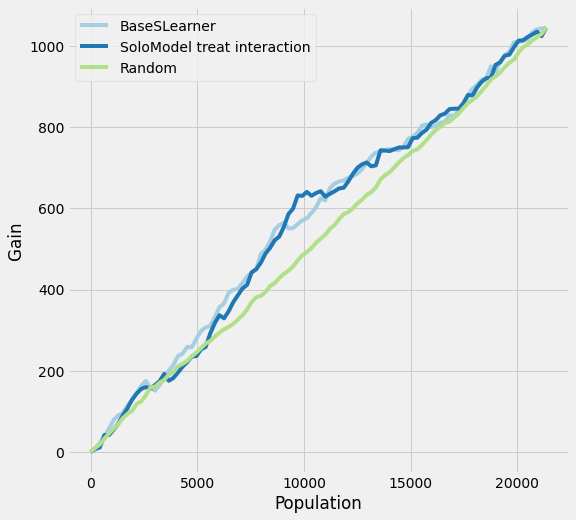

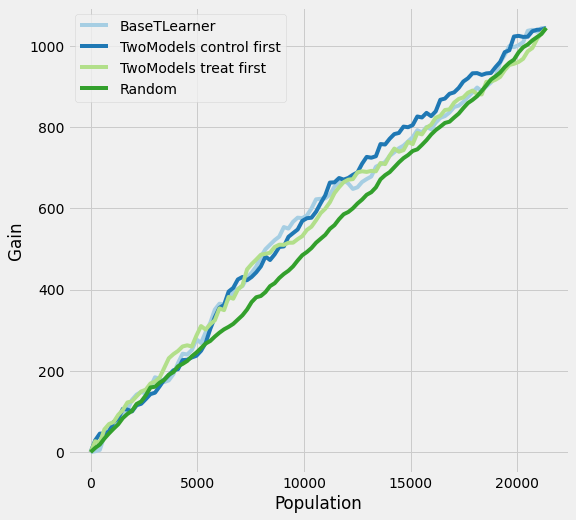

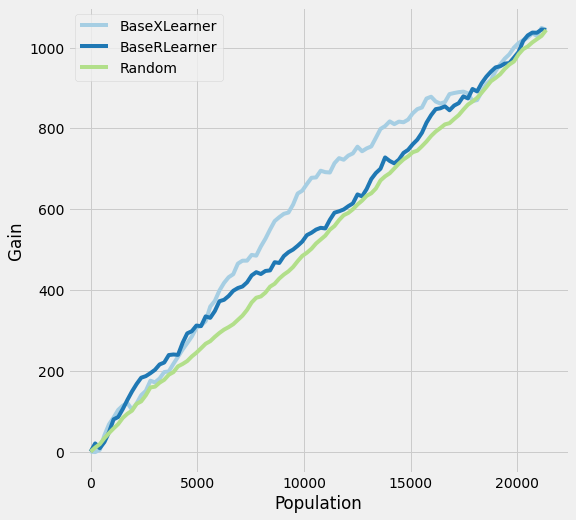

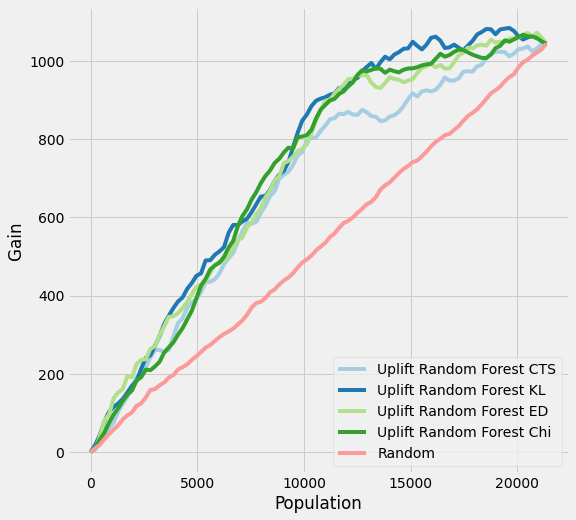

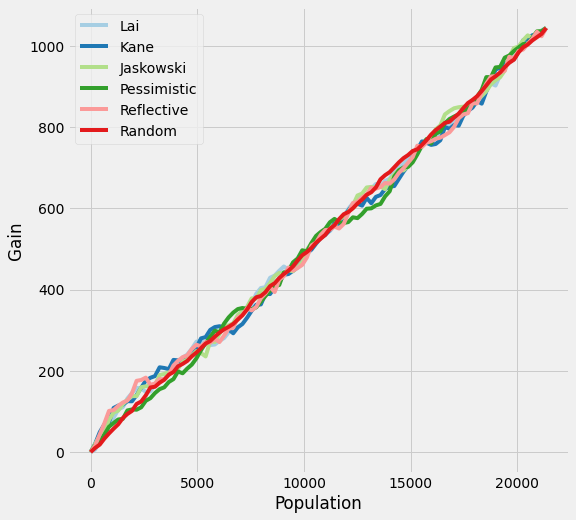

In [17]:
df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseSLearner': cate_s_test.flatten(),
                   'SoloModel treat interaction': pred_2.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

S_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseTLearner': cate_t_test.flatten(),
                   'TwoModels control first': pred_5.flatten(), 'TwoModels treat first': pred_6.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

T_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'BaseXLearner': cate_x_test.flatten(), 'BaseRLearner': cate_r_test.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

XR_Learner = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Uplift Random Forest CTS': forest_CTS.flatten(), 'Uplift Random Forest KL': forest_KL.flatten(),
                   'Uplift Random Forest ED': forest_ED.flatten(), 'Uplift Random Forest Chi': forest_Chi.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

URF = auuc_score(df, outcome_col='y', treatment_col='w')

df = pd.DataFrame({'y': y_test, 'w': w_test, 'Lai': pred_lai.flatten(), 'Kane': pred_kane.flatten(), 'Jaskowski': pred_jask.flatten(), 'Pessimistic': pred_pess.flatten(), 'Reflective': pred_refl.flatten()})
plot_gain(df, outcome_col='y', treatment_col='w')
plt.show()

ClassTransf = auuc_score(df, outcome_col='y', treatment_col='w')

In [18]:
print("Area under the uplift curves:")
print(S_Learner)
print(T_Learner)
print(XR_Learner)
print(URF)
print(ClassTransf)

Area under the uplift curves:
BaseSLearner                   0.544911
SoloModel treat interaction    0.540189
Random                         0.500102
dtype: float64
BaseTLearner               0.539733
TwoModels control first    0.547306
TwoModels treat first      0.536016
Random                     0.500102
dtype: float64
BaseXLearner    0.573795
BaseRLearner    0.533888
Random          0.500102
dtype: float64
Uplift Random Forest CTS    0.647310
Uplift Random Forest KL     0.707254
Uplift Random Forest ED     0.684946
Uplift Random Forest Chi    0.684969
Random                      0.500102
dtype: float64
Lai            0.503242
Kane           0.499756
Jaskowski      0.504136
Pessimistic    0.495690
Reflective     0.500208
Random         0.500102
dtype: float64
